In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../datasets")
sys.path.insert(0,"../dimred")
# import utils


In [2]:
from data.loader import LoadOne
from models.linear.transform import Kurtosis
from models.linear.transform import co_variance,co_kurtosis

from tester.plotting import plot_embedding


In [3]:
loader = LoadOne()

data = loader.getData()


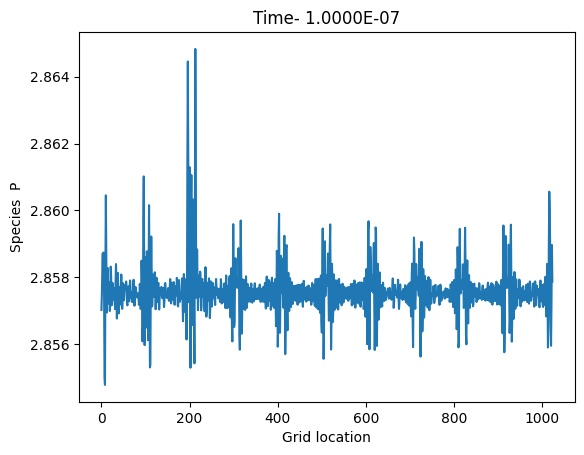

In [4]:
loader.plotLine(spec=13,time=1)

## Dim reduction

In [5]:
X = data[100]

clf = Kurtosis()


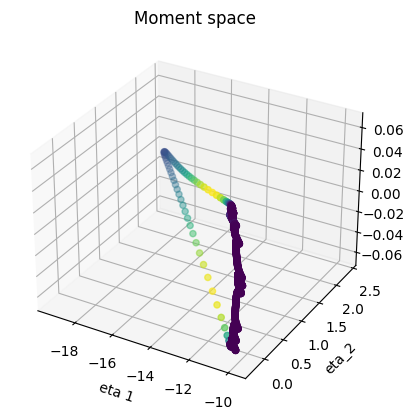

In [6]:
xr = clf.fit_transform(X)

plot_embedding(xr,color_spec=X[:,10])

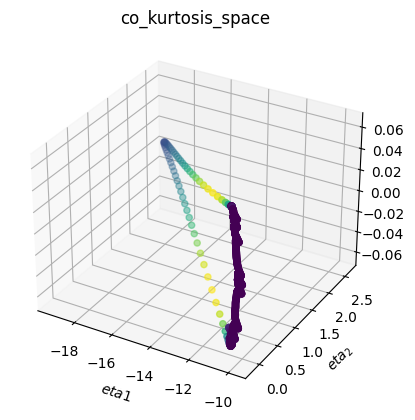

In [9]:

clf.fit(X,moment=co_kurtosis)
xr = clf.transform(X)

plot_embedding(xr,color_spec=X[:,10],titler="co_kurtosis_space")

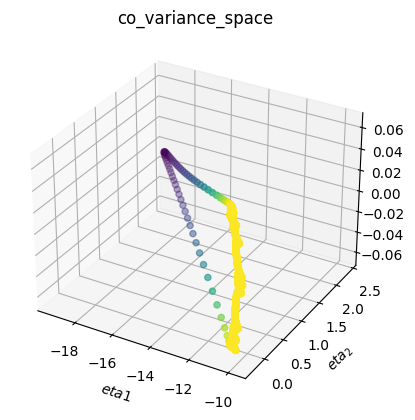

In [11]:

clf.fit(X,moment=co_variance)
xr = clf.transform(X)

plot_embedding(xr,color_spec=X[:,1],titler="co_variance_space")

## Reconstruction

In [25]:
from models.linear.moments import calculate_cokutosis_tensor,calculate_covariance_matrix

In [4]:
from unsup.utils import co_variance, co_kurtosis
def eigens(x,method=co_variance):
    cm = method(x)    
    V,S,U = np.linalg.svd(cm)
    return S,U

In [6]:
# mdat = loadPickle("../data/dataFine.dat")
ndat = np.load("../data/synth/onedFine.npy")[:,:-4]

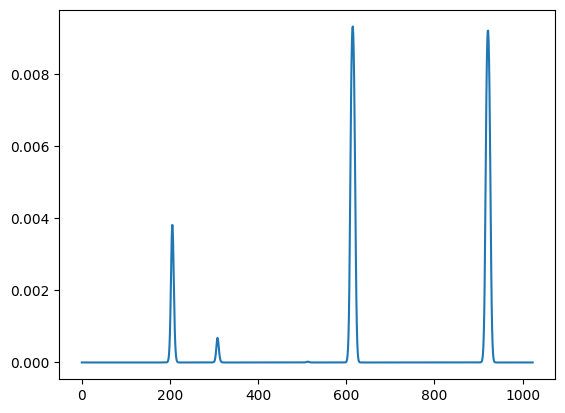

In [7]:
mdat = np.load("../data/synth/multiFine.npy")[::2,:-4]
plt.plot(mdat[50,3])

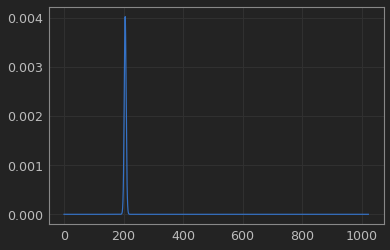

In [8]:
plt.plot(ndat[50,3])

In [9]:
print(mdat.shape)
ndat.shape


(201, 13, 1024)


(201, 13, 1024)

In [10]:
fdat = ndat[50].T

s1,u1 = eigens(fdat)
s2,u2 = eigens(fdat,co_kurtosis)

In [32]:
# s1

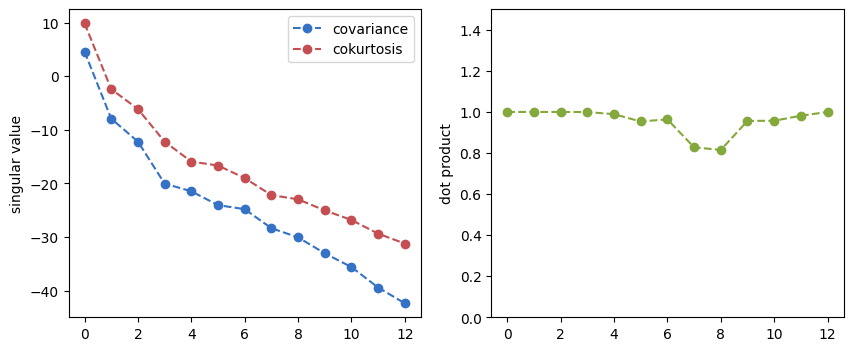

In [11]:
def plotSpectra(s1,s2,u1,u2):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.plot(np.log(s1),'--ob',label='covariance')
    ax1.plot(np.log(s2),'--or',label='cokurtosis')
    ax1.set_ylabel('singular value')
    ax1.legend()
    dots = [abs(v1@v2) for v1,v2 in zip(u1,u2)]
    ax2.plot(dots,'--og')
    ax2.set_ylabel('dot product')
    ax2.set_ylim(0,1.5)

    plt.show()

plotSpectra(s1,s2,u1,u2)


In [12]:
from ipywidgets import interact
from unsup.utils import MinMaxScalar

from unsup.utils import scaleData

In [79]:
scaleDataeData??

In [13]:
preprocess = lambda dat : np.array([MinMaxScalar(x) for x in dat])

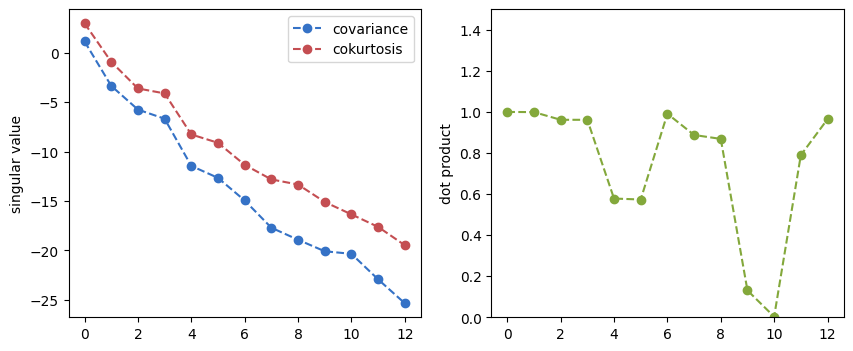

In [14]:
def f(i):
#     x = bigDat[i].values
    x = preprocess(ndat[i]).T
    s1,u1 = eigens(x)
    s2,u2 = eigens(x,co_kurtosis)

    plotSpectra(s1,s2,u1,u2)

f(20)

In [93]:
interact(f,i=range(1,201))

interactive(children=(Dropdown(description='i', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

<function __main__.f(i)>

In [40]:
arr.squeeze

<function ndarray.squeeze>

In [15]:
totalDots = []
for i in range(40):
    x = preprocess(ndat[4*i+5]).T
    
    s1,u1 = eigens(x)
    s2,u2 = eigens(x,co_kurtosis)
    dots = [abs(v1@v2) for v1,v2 in zip(u1,u2)]
    
    totalDots.append(dots)


In [13]:
filers = open('../datasets/methane/variables.txt')
# ychen = filers.read()

In [10]:
import imp

In [37]:
info = imp.load_source('variables','../datasets/methane/variables.txt')

In [39]:
info.fnameoffset

13

In [35]:
vars.__class__

builtin_function_or_method

In [26]:
arr = np.fromfile('../datasets/methane/autoignition.1.5000E-05.field.mpi')


In [30]:
arr.shape[0]/1024

17.0

In [21]:
dat.vars

'time, Y_h2, Y_o2, Y_o, Y_oh, Y_h2o, Y_h, Y_ho2, Y_h2o2, Y_n2, temp, P_h2, P_o2, P_o, P_oh, P_h2o, P_h, P_ho2, P_h2o2, P_n2'

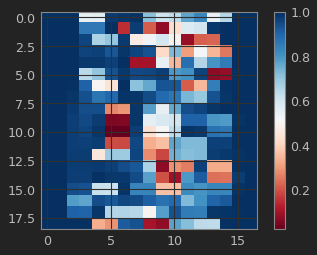

In [52]:
plt.imshow(totalDots[:-1],cmap="RdBu",aspect=0.9)
plt.colorbar()

Text(0.5, 1.0, 'Heatmap of vector orientations')

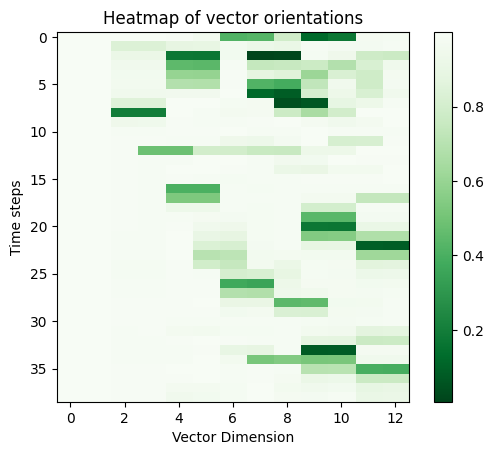

In [19]:
plt.imshow(totalDots[:-1],cmap="Greens_r",aspect=0.35)
plt.colorbar()
plt.xlabel("Vector Dimension")
plt.ylabel("Time steps")
plt.title("Heatmap of vector orientations")

## Zero Dim Combustion

In [2]:
species = ['time', 'Y_h2', 'Y_o2', 'Y_o', 'Y_oh', 'Y_h2o', 'Y_h', 'Y_ho2', 'Y_h2o2', 'Y_n2', 'temp', 'P_h2', 'P_o2', 'P_o', 'P_oh', 'P_h2o', 'P_h', 'P_ho2', 'P_h2o2', 'P_n2']

In [7]:
', '.join(specs)

'H2, O2, O, OH, H2O, H, HO2, H2O2, CO, CO2, HCO, N2, T, P, vx, vy, vz'

In [5]:
specs = ['H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'H2O2', 'CO', 'CO2', 'HCO','N2', 'T', 'P', 'vx', 'vy', 'vz']

In [6]:
len(specs)

17

In [101]:
ndat.shape

(201, 13, 1024)

Reclaim

In [102]:
from unsup.utils import co_kurtosis,co_variance,MeanMaxScalar,MinMaxScalar

def encode(x,nretain=5,method=co_variance):
    cm = method(x)
    V,S,U = np.linalg.svd(cm,full_matrices=False)
    pc = U[:nretain].T ### U[:1] num of vectors to chose
    xr = np.dot(x,pc)
#     xe = np.outer(xr,pc)
    return xr ## encoded set

In [19]:
co_variance??

Eigne spectrum

In [ ]:
dof:  
    data
    encod
    nretain
    varz
    decode
    

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

def decode(z,xp,model):
    model.fit(xp,z)
    zp = model.predict(xp)
    return zp

modeldict = {
    'linear' : LinearRegression(),
    'svm' : SVR(),
    'forest': RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100),
    'knn' : KNeighborsRegressor(),
    'neural' : MLPRegressor()
}

momdict = {
    'variance' : co_variance,
    'kurtosis' : co_kurtosis
}

In [112]:
def mse(a,ap):
    return np.mean((a-ap)**2)

def tse(x,y):
    _conv = lambda x : np.array(x).T    
    x = _conv(x)
    y = _conv(y)
    return np.linalg.norm(x-y,ord=1,axis=1).sum()

mse = lambda a,ap: np.mean(np.abs(a-ap))

In [12]:
varid = {v:i for i,v in enumerate(species)}

In [14]:
varid['temp']

10

In [107]:
mdat.shape

(201, 13, 1024)

In [116]:
def single(ax,xr,nretain,varz,embed,debed,namer=''):
    xs = preprocess(xr).T#,scalar=MinMaxScalar)
    xp = encode(xs,nretain,method=embed)
    z1 = xr[varz]
    zp  = decode(z1,xp,model=debed)

    a1,b1 = xp.T[:2]

    ax.scatter(a1,b1,z1,marker="o",label="Original")
    ax.scatter(a1,b1,zp,marker="o",label=namer,c='r')
    ax.set_xlabel("eta 1")
    ax.set_ylabel("eta_2")
    ax.set_title(specs[varz]+namer)
    plt.legend()
    
    return mse(zp,z1)
    
def combine(xs,nretain,varz,debed):
#     xs = loadDat(fname)

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121, projection='3d')
    e0 = single(ax,xs,nretain,varz,co_variance,debed,'variance')
    ax1 = fig.add_subplot(122, projection='3d')
    e1 = single(ax1,xs,nretain,varz,co_kurtosis,debed,'kurtosis')
    plt.show()
    
    print(e0,"--"*10,e1)

In [114]:
plt.style.use('default')

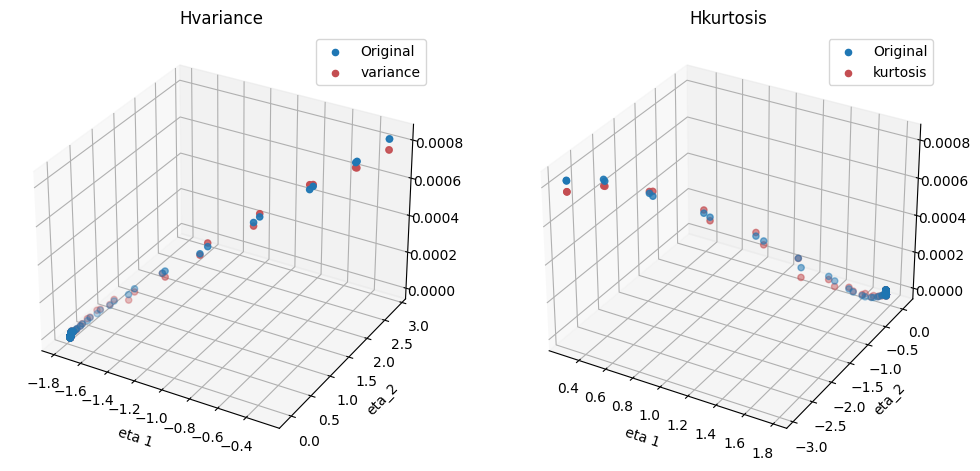

4.045065175542902e-07 -------------------- 4.371196410983339e-07


In [117]:
combine(ndat[50],nretain=4,varz=5,debed=KNeighborsRegressor())

In [169]:
xr = ndat[60]
nretain = 4
embed = co_kurtosis
debed = RandomForestRegressor()
varz = range(12)

xs = preprocess(xr).T#,scalar=MinMaxScalar)

xp = encode(xs,nretain,method=embed)
z1 = xs.T[varz].T
zp  = decode(z1,xp,model=debed)



Text(0, 0.5, 'histogram')

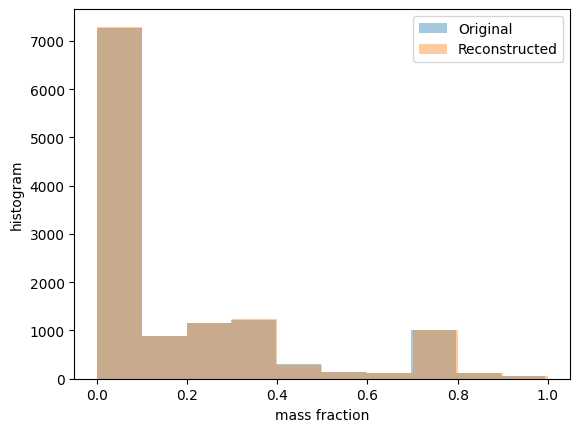

In [170]:
plt.hist(zp.reshape(-1),alpha=0.4,label="Original")
plt.hist(z1.reshape(-1),alpha=0.4,label="Reconstructed")
plt.legend()
plt.xlabel("mass fraction")
plt.ylabel("histogram")

In [108]:
MinMaxScalar??

In [157]:
species

['time',
 'Y_h2',
 'Y_o2',
 'Y_o',
 'Y_oh',
 'Y_h2o',
 'Y_h',
 'Y_ho2',
 'Y_h2o2',
 'Y_n2',
 'temp',
 'P_h2',
 'P_o2',
 'P_o',
 'P_oh',
 'P_h2o',
 'P_h',
 'P_ho2',
 'P_h2o2',
 'P_n2']

In [158]:
xs.shape

(1024, 17)

In [188]:
xs.min()

0.0

In [193]:
def makesource(dat):
    _,h2,o2,o,oh,h2o,h = dat[:7]
    return 1.12*np.exp(-3.1*(h2+o2)+4.23*(o+oh+h))

In [189]:
xs.shape

(1024, 17)

In [194]:
zz = makesource(xs.T)

Text(0.5, 0, 'grid list')

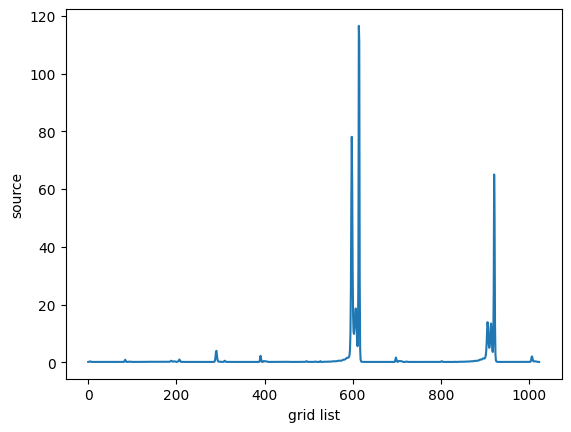

In [196]:
plt.plot(zz)
plt.ylabel("source")
plt.xlabel("grid list")

In [216]:
xs

array([[2.30527003e-01, 7.44168925e-01, 4.71391860e-05, ...,
        1.23390699e-01, 0.00000000e+00, 0.00000000e+00],
       [2.30519821e-01, 7.44136147e-01, 5.81519145e-05, ...,
        5.31448756e-02, 9.77517107e-04, 0.00000000e+00],
       [2.58671139e-01, 7.53482174e-01, 3.66517496e-02, ...,
        0.00000000e+00, 1.95515481e-03, 3.65899143e-02],
       ...,
       [2.30552360e-01, 7.44275307e-01, 1.15063323e-05, ...,
        3.57007805e-02, 9.98044966e-01, 0.00000000e+00],
       [2.30545383e-01, 7.44248566e-01, 2.06394345e-05, ...,
        1.03019028e-01, 9.99022483e-01, 0.00000000e+00],
       [2.30536403e-01, 7.44210863e-01, 3.32266334e-05, ...,
        1.39345901e-01, 1.00000000e+00, 0.00000000e+00]])

In [220]:
errs = []
for _,momf in momdict.items():
    t = []
    xp = encode(xs,6,method=momf)
    for name,mode in modeldict.items():
        zzp = decode(zz,xp,mode)
        t.append(np.mean((zzp-zz)**2)**0.5)
    errs.append(t)

/home/shubham/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shubham/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [218]:
import pandas as pd

In [221]:
df = pd.DataFrame(errs).T
df

,0,1
0,4.515190,4.525406
1,5.899916,5.898589
2,0.655999,0.665766
3,2.685616,2.677823
4,4.525126,4.318257


In [225]:
df.index = modeldict.keys()

In [226]:
df

,0,1
linear,4.515190,4.525406
svm,5.899916,5.898589
forest,0.655999,0.665766
knn,2.685616,2.677823
neural,4.525126,4.318257


In [215]:
plt.xticks??

<AxesSubplot:>

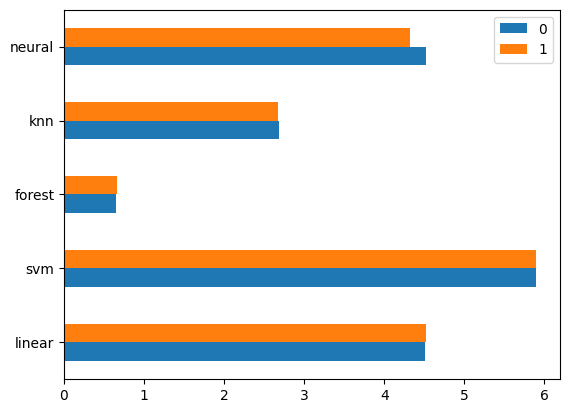

In [229]:
df.plot.barh(style="seaborn")

Text(0.5, 0, 'grid list')

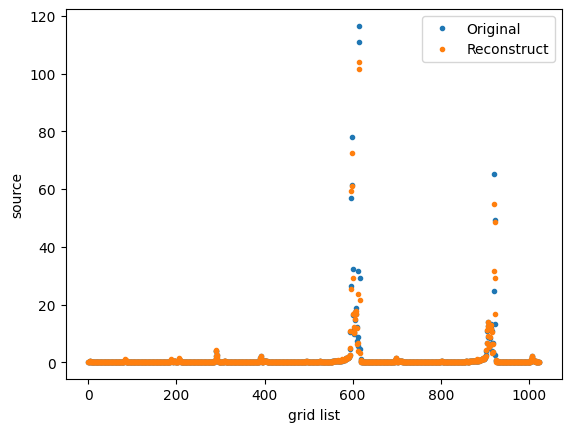

In [203]:

plt.plot(zz,'.',label="Original")
plt.plot(zzp,".",label="Reconstruct")

plt.legend()
plt.ylabel("source")
plt.xlabel("grid list")

In [207]:
err = np.mean(zzp - zz)
err

-0.017584135255825906

Text(0, 0.5, '$x_2$')

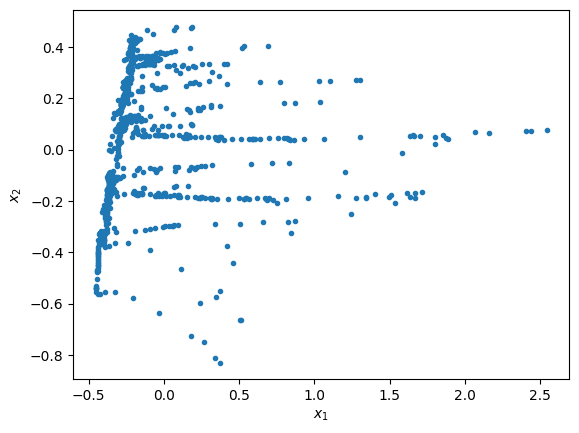

In [155]:
plt.plot(*xp.T[1:3],'.')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")


Text(0.5, 0, 'Grid points')

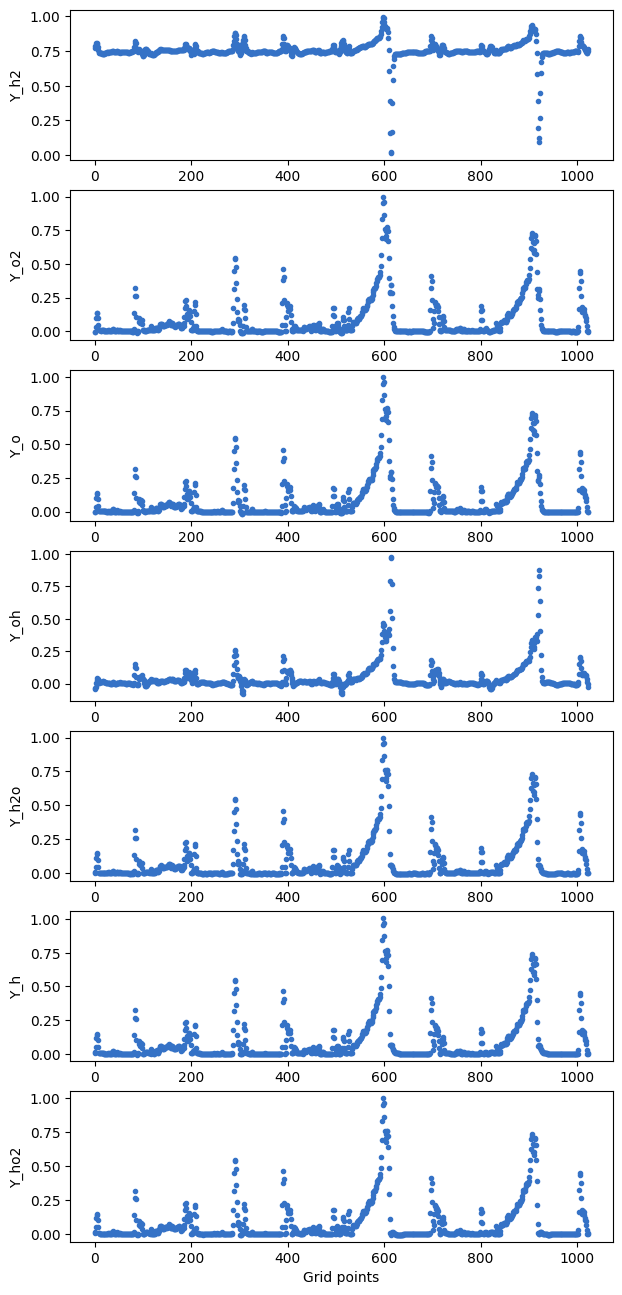

In [156]:
pltsp = range(1,8)

fig,ax = plt.subplots(7,figsize=(7,16))
for i,k in enumerate(pltsp):
    ax[i].plot(zp.T[k],'b.')
#     ax[i].plot(z1.T[k],'r.')
    ax[i].set_ylabel(species[k])

ax[i].set_xlabel("Grid points")


Text(0, 0.5, 'Reconstructed')

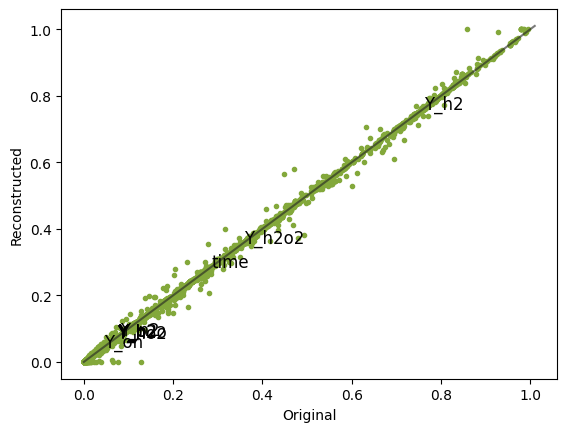

In [204]:
rr = [0.,1.01]
for k in range(10):
#     k = 0
    a,b = zp.T[k],z1.T[k]
    plt.plot(a,b,".g")
    plt.text(a.mean() * (1 + 0.01), b.mean() * (1 + 0.01) , species[k], fontsize=12)
plt.plot(rr,rr,'k',alpha=0.6)
plt.xlabel("Original")
plt.ylabel("Reconstructed")


Text(0, 0.5, 'Avg Error')

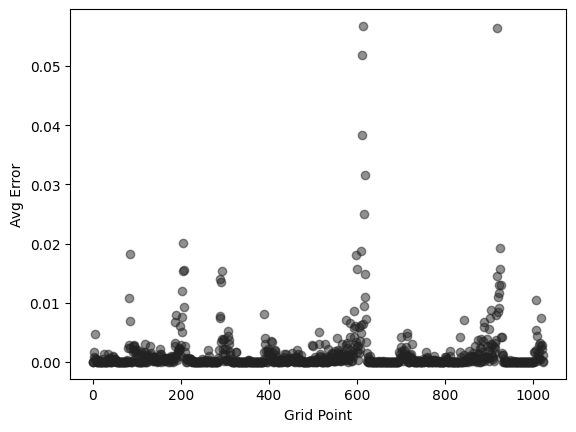

In [205]:
plt.plot(np.abs(zp-z1).mean(axis=1),"ko",alpha=0.5)
plt.ylim()
plt.xlabel("Grid Point")
plt.ylabel("Avg Error")

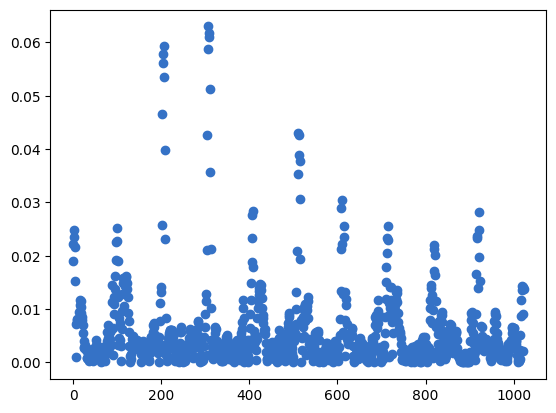

In [127]:
plt.plot(np.abs(a-b),"bo")

In [ ]:

plt












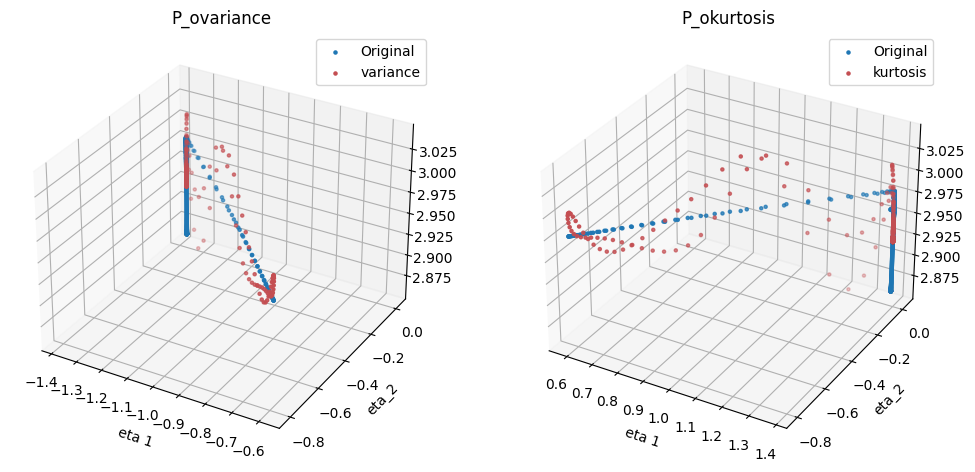

0.03480954255069319 -------------------- 0.03474721675978795


In [35]:
combine(ndat[100].T,nretain=4,varz=13,debed=LinearRegression())

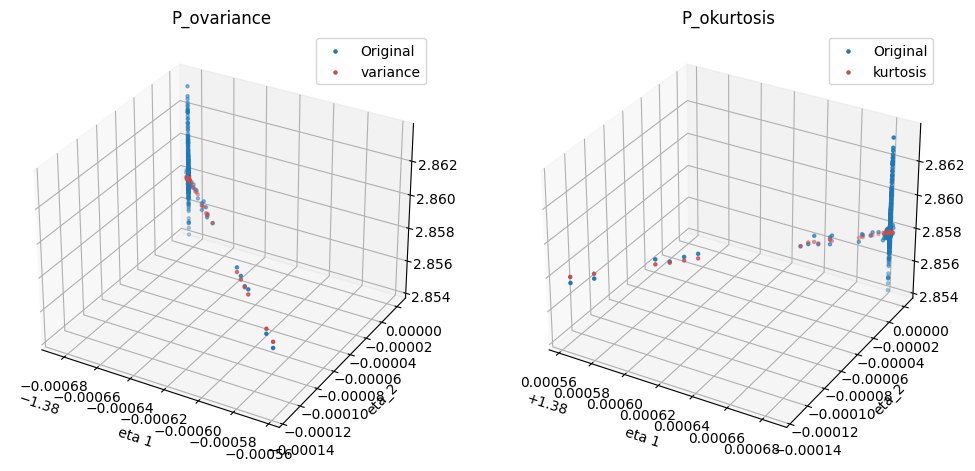

0.0005281396925783778 -------------------- 0.0005281397035921927


In [32]:
combine(mdat[10],nretain=4,varz=13,debed=LinearRegression())

In [90]:
interact(combine,fname=flist,nretain=3,varz=varid,debed=modeldict)    

interactive(children=(Dropdown(description='fname', options=('h2_1150_0.3.npy', 'h2_1050_0.1.npy', 'h2_1100_0.…

<function __main__.combine(fname, nretain, varz, debed)>

In [77]:
# flist